Сохранение изображения в виде текстового файла.

In [3]:
import cv2
import numpy as np

# Загрузка изображения
image = cv2.imread("sar_1_gray.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

np.savetxt('image_data.txt', gray, fmt='%d')

print("Изображение сохранено в image_data.txt")

Изображение сохранено в image_data.txt


Реализация вейвлет-преобразование Хаара для изображения

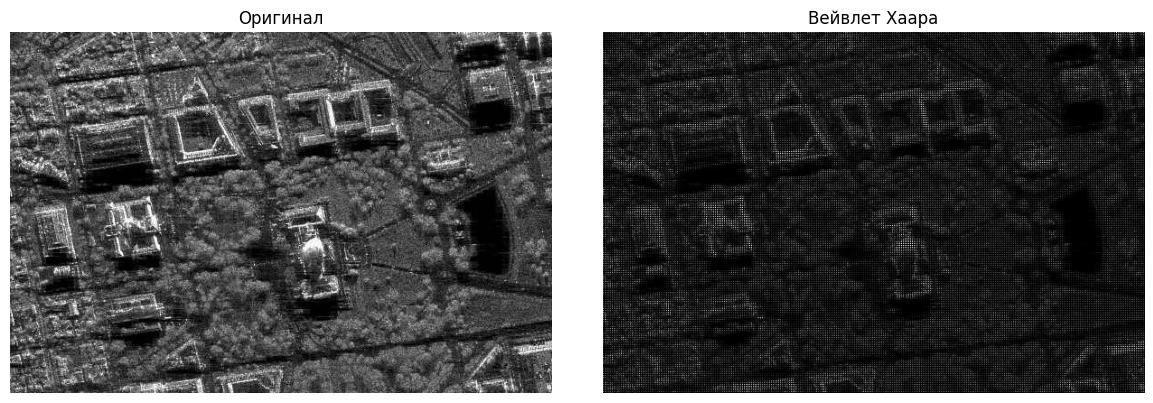

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("sar_1_gray.jpg", cv2.IMREAD_GRAYSCALE)

def haar_transform(img):
    h, w = img.shape
    for i in range(h):
        for j in range(0, w - 1, 2):
            avg = (img[i, j] + img[i, j + 1]) / 2
            diff = (img[i, j] - img[i, j + 1]) / 2
            img[i, j] = avg
            img[i, j + 1] = diff
    
    for j in range(w):
        for i in range(0, h - 1, 2):
            avg = (img[i, j] + img[i + 1, j]) / 2
            diff = (img[i, j] - img[i + 1, j]) / 2
            img[i, j] = avg
            img[i + 1, j] = diff
    
    return img

haar_result = haar_transform(image.copy().astype(float))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Оригинал")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.abs(haar_result), cmap='gray')
plt.title("Вейвлет Хаара")
plt.axis('off')

plt.tight_layout()
plt.show()

Квантование высокочастотных компонент

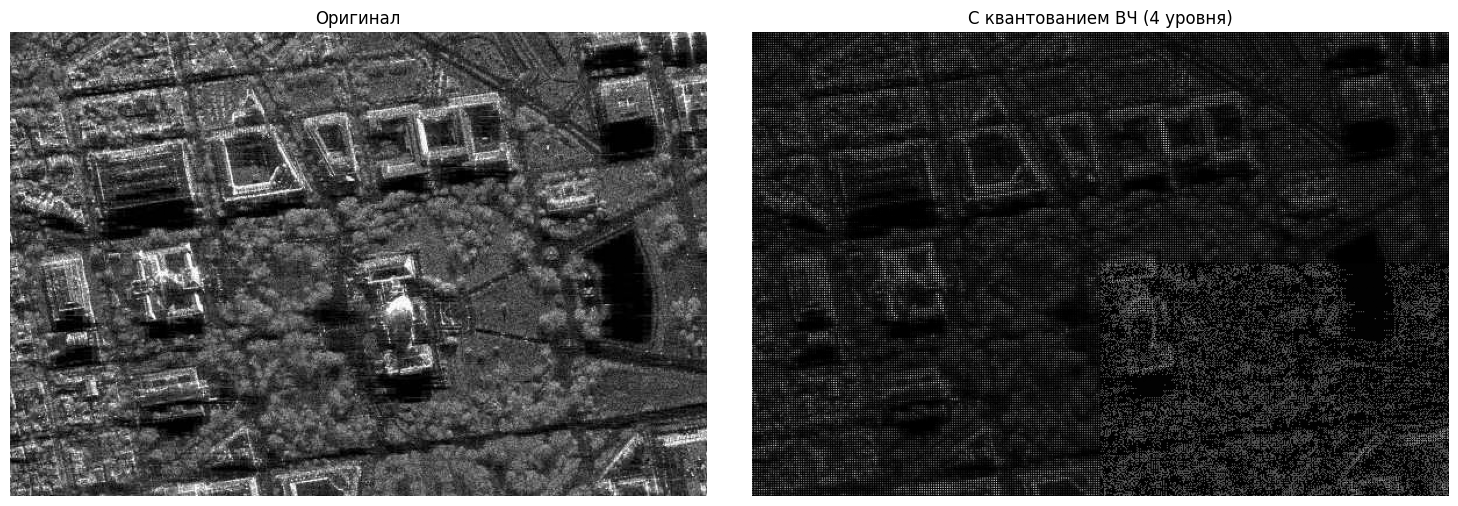

In [18]:
def quantize_high_freq(haar_img, num_quants=4):
    h, w = haar_img.shape
    quantized = haar_img.copy()
    
    # Высокочастотные компоненты (правый нижний квадрант)
    mid_h, mid_w = h // 2, w // 2
    
    # Квантуем высокочастотную область
    high_freq_region = quantized[mid_h:, mid_w:]
    
    # Определяем уровни квантования
    min_val = np.min(high_freq_region)
    max_val = np.max(high_freq_region)
    step = (max_val - min_val) / num_quants
    
    # Применяем квантование
    for i in range(high_freq_region.shape[0]):
        for j in range(high_freq_region.shape[1]):
            val = high_freq_region[i, j]
            quant_level = int((val - min_val) / step)
            quant_level = min(quant_level, num_quants - 1)
            high_freq_region[i, j] = min_val + quant_level * step
    
    quantized[mid_h:, mid_w:] = high_freq_region
    return quantized

# Применение преобразования
haar_result = haar_transform(image.copy().astype(float))

# Квантование высокочастотных компонент
quantized_result = quantize_high_freq(haar_result.copy(), num_quants=4)

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Оригинал")
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(np.abs(quantized_result), cmap='gray')
plt.title("С квантованием ВЧ (4 уровня)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import os

image = cv2.imread("sar_1_gray.jpg", cv2.IMREAD_GRAYSCALE)

def haar_transform_components(img):
    h, w = img.shape
    temp = img.copy().astype(float)
    
    for i in range(h):
        for j in range(0, w - 1, 2):
            avg = (temp[i, j] + temp[i, j + 1]) / 2
            diff = (temp[i, j] - temp[i, j + 1]) / 2
            temp[i, j] = avg
            temp[i, j + 1] = diff
    
    for j in range(w):
        for i in range(0, h - 1, 2):
            avg = (temp[i, j] + temp[i + 1, j]) / 2
            diff = (temp[i, j] - temp[i + 1, j]) / 2
            temp[i, j] = avg
            temp[i + 1, j] = diff
    
    mid_h, mid_w = h // 2, w // 2
    LL = temp[:mid_h, :mid_w]
    LH = temp[:mid_h, mid_w:]
    HL = temp[mid_h:, :mid_w]
    HH = temp[mid_h:, mid_w:]
    
    return LL, LH, HL, HH

def rle_encode(data):
    encoded = []
    count = 1
    prev_val = data[0]
    
    for val in data[1:]:
        if val == prev_val:
            count += 1
        else:
            encoded.append((prev_val, count))
            prev_val = val
            count = 1
    encoded.append((prev_val, count))
    return encoded

LL, LH, HL, HH = haar_transform_components(image)

def quantize_component(component, num_quants=4):
    min_val = np.min(component)
    max_val = np.max(component)
    step = (max_val - min_val) / num_quants
    
    quantized = component.copy()
    for i in range(component.shape[0]):
        for j in range(component.shape[1]):
            val = component[i, j]
            quant_level = int((val - min_val) / step)
            quant_level = min(quant_level, num_quants - 1)
            quantized[i, j] = min_val + quant_level * step
    
    return quantized

LH_quant = quantize_component(LH)
HL_quant = quantize_component(HL)
HH_quant = quantize_component(HH)

LH_rle = rle_encode(LH_quant.flatten())
HL_rle = rle_encode(HL_quant.flatten())
HH_rle = rle_encode(HH_quant.flatten())

with open('haar_components.txt', 'w') as f:
    f.write("LL:\n")
    np.savetxt(f, LL, fmt='%.6f')
    
    f.write("\nLH (RLE):\n")
    for val, count in LH_rle:
        f.write(f"{val:.6f},{count}\n")
    
    f.write("\nHL (RLE):\n")
    for val, count in HL_rle:
        f.write(f"{val:.6f},{count}\n")
    
    f.write("\nHH (RLE):\n")
    for val, count in HH_rle:
        f.write(f"{val:.6f},{count}\n")

original_size = image.nbytes
ll_size = LL.nbytes
lh_size = len(str(LH_rle))  
hl_size = len(str(HL_rle))
hh_size = len(str(HH_rle))
compressed_size = ll_size + lh_size + hl_size + hh_size

print(f"Объем исходного изображения: {original_size} байт")
print(f"Объем сжатых данных: {compressed_size} байт")
print(f"Коэффициент сжатия: {original_size/compressed_size:.2f}:1")
print("Данные сохранены в файл 'haar_components.txt'")

Объем исходного изображения: 240000 байт
Объем сжатых данных: 2758926 байт
Коэффициент сжатия: 0.09:1
Данные сохранены в файл 'haar_components.txt'
